Train Normal: 70
Train Pneumonia: 3883
Test Normal: 234
Test Pneumonia: 390
Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.9747 - loss: 0.1502 - val_accuracy: 1.0000 - val_loss: 0.0240
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.9797 - loss: 0.0977 - val_accuracy: 1.0000 - val_loss: 0.0296
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.9804 - loss: 0.0922 - val_accuracy: 1.0000 - val_loss: 0.0179
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.9804 - loss: 0.0906 - val_accuracy: 1.0000 - val_loss: 0.0161
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.9802 - loss: 0.0900 - val_accuracy: 1.0000 - val_loss: 0.0194
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.9743 - loss: 0.1102 - val_accuracy: 1.0000 - val_loss: 0.0163
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.9819 - loss: 0.0797 - val_accuracy: 1.0000 - val_loss: 0.0287
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━

Model saved as pneumonia_model.h5

Evaluating on test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.3012 - loss: 3.9780
Test Accuracy: 62.66%
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.00      0.01       234
   Pneumonia       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.81      0.50      0.39       624
weighted avg       0.77      0.63      0.48       624



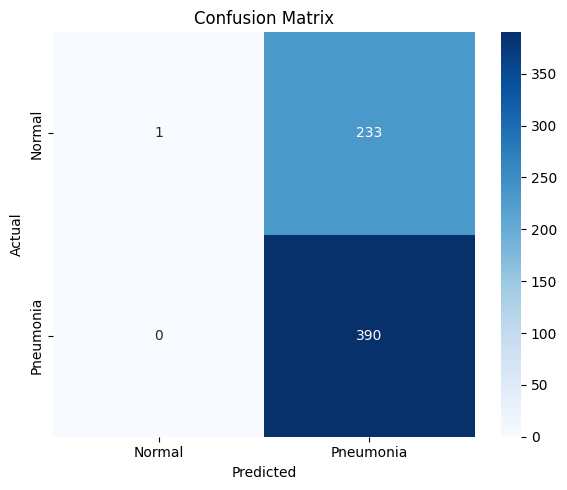

In [1]:
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. Load Dataset Using glob
# ===============================
train_normal = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\train\NORMAL\*.*")
train_pneumonia = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\train\PNEUMONIA\*.*")
test_normal = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\test\NORMAL\*.*")
test_pneumonia = glob.glob(r"D:\Downloads\pnemonia_extract\Pediatric Chest X-ray Pneumonia\test\PNEUMONIA\*.*")

print("Train Normal:", len(train_normal))
print("Train Pneumonia:", len(train_pneumonia))
print("Test Normal:", len(test_normal))
print("Test Pneumonia:", len(test_pneumonia))

train_images = []
train_labels = []

for path in train_normal:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    train_images.append(img_to_array(img))
    train_labels.append(0)

for path in train_pneumonia:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    train_images.append(img_to_array(img))
    train_labels.append(1)

test_images = []
test_labels = []

for path in test_normal:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    test_images.append(img_to_array(img))
    test_labels.append(0)

for path in test_pneumonia:
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    test_images.append(img_to_array(img))
    test_labels.append(1)

# Normalize and convert to numpy arrays
train_x = np.array(train_images, dtype='float32') / 255.0
train_y = np.array(train_labels)
test_x = np.array(test_images, dtype='float32') / 255.0
test_y = np.array(test_labels)

# ===============================
# 2. CNN + LSTM Hybrid Model
# ===============================
inputs = Input(shape=(224, 224, 3))
x = Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal')(inputs)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, kernel_size=3, activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(2, 2)(x)
x = Reshape((-1, 32))(x)
x = LSTM(64)(x)
x = Dense(32, activation='elu', kernel_initializer='he_uniform')(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# ===============================
# 3. Compile and Train
# ===============================
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_x, train_y, epochs=20, validation_split=0.2)

model.save('pneumonia_model.h5')
print("Model saved as pneumonia_model.h5")

# ===============================
# 4. Evaluation
# ===============================
print("\nEvaluating on test data...")
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predictions
pred_y = np.argmax(model.predict(test_x), axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(test_y, pred_y, target_names=['Normal', 'Pneumonia']))

# Confusion Matrix
cm = confusion_matrix(test_y, pred_y)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [8]:
pip install tensorflow

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl (2.9 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl (209 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached grpcio-1.73.1-cp310-cp310-win_amd64.whl (4.3 MB)
  Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
  Using cached rich-14.0.0-py3-none-any.whl (243 kB)
  Using cached markdown-3.8.2-py3-none-any.whl (106 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install --upgrade typing_extensions


  Using cached typing_extensions-4.14.1-py3-none-any.whl (43 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.14.0
    Uninstalling typing_extensions-4.14.0:
      Successfully uninstalled typing_extensions-4.14.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,606,529 (9.94 MB)

 Trainable params: 348,545 (1.33 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

c:\Users\GANDHIRAJ J\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7237 - loss: 0.5272

131/131 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.7244 - loss: 0.5263 - val_accuracy: 0.9288 - val_loss: 0.2141
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9225 - loss: 0.2060

131/131 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9226 - loss: 0.2059 - val_accuracy: 0.9529 - val_loss: 0.1469
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9375 - loss: 0.1695

131/131 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9375 - loss: 0.1695 - val_accuracy: 0.9510 - val_loss: 0.1402
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9468 - loss: 0.1350 - val_accuracy: 0.9500 - val_loss: 0.1423
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9537 - loss: 0.1243 - val_accuracy: 0.9462 - val_loss: 0.1425
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9527 - loss: 0.1206

131/131 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9527 - loss: 0.1205 - val_accuracy: 0.9558 - val_loss: 0.1162
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9635 - loss: 0.1013 - val_accuracy: 0.9433 - val_loss: 0.1527
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9664 - loss: 0.0943 - val_accuracy: 0.9587 - val_loss: 0.1232
Epoch 9/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9613 - loss: 0.1019

131/131 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9614 - loss: 0.1019 - val_accuracy: 0.9587 - val_loss: 0.1123
Epoch 10/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9617 - loss: 0.0957 - val_accuracy: 0.9548 - val_loss: 0.1259
Epoch 11/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9691 - loss: 0.0832

131/131 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9691 - loss: 0.0832 - val_accuracy: 0.9654 - val_loss: 0.1009
Epoch 12/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9689 - loss: 0.0835 - val_accuracy: 0.9510 - val_loss: 0.1330
Epoch 13/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9639 - loss: 0.0923 - val_accuracy: 0.9615 - val_loss: 0.1120
Epoch 14/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9677 - loss: 0.0919 - val_accuracy: 0.9587 - val_loss: 0.1092
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - accuracy: 0.7914 - loss: 0.6679

✅ Test Accuracy: 86.38%
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 593ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.93      0.69      0.79       234
     Opacity       0.84      0.97      0.90       390

    accuracy                           0.86       624
   macro avg       0.88      0.83      0.85       624
weighted avg       0.87      0.86      0.86       6

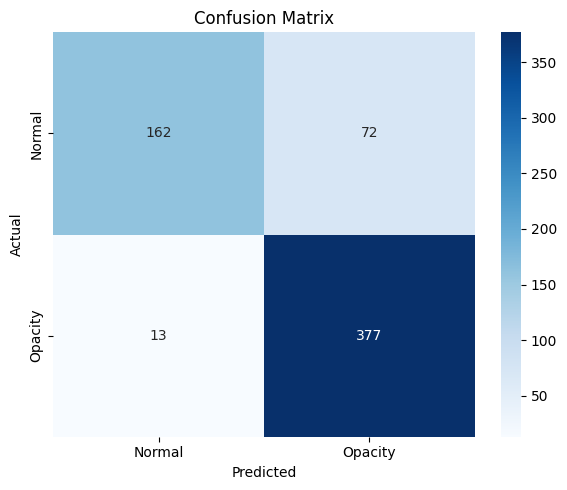

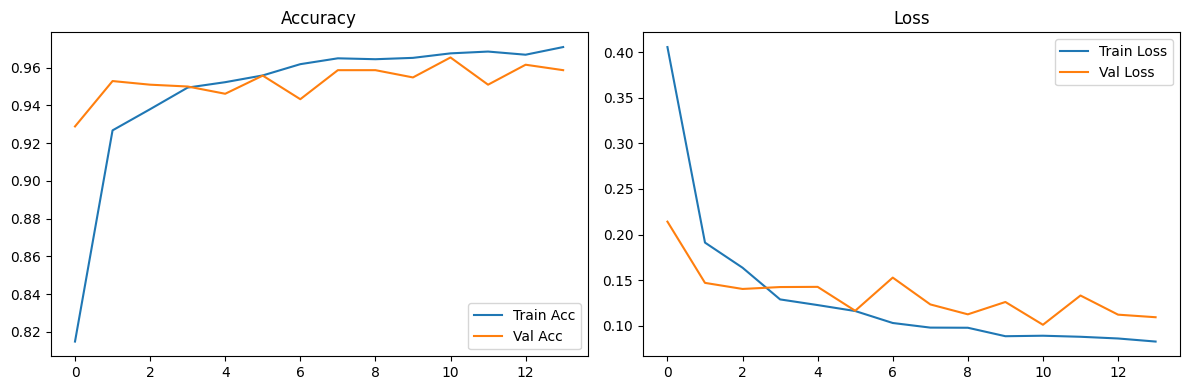

✅ Model saved as final_mobilenet_lstm_model.h5


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ================================
# 1. Dataset Paths
# ================================
base_dir =r"D:\Project Dataset\pneumonia"  # ✅ Update if needed
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# ================================
# 2. Image Preprocessing
# ================================
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)

# ================================
# 3. Model: MobileNetV2 + LSTM
# ================================
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output  # Shape: (None, 7, 7, 1280)
x = Reshape((49, 1280))(x)   # Flatten HxW -> sequence for LSTM
x = LSTM(64)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# ================================
# 4. Training with Callbacks
# ================================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model_mobilenet_lstm.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

# ================================
# 5. Evaluation on Test Set
# ================================
loss, acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

y_probs = model.predict(test_gen)
y_pred = (y_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Opacity']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Opacity'], yticklabels=['Normal', 'Opacity'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ================================
# 6. Accuracy and Loss Plots
# ================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.tight_layout()
plt.show()

# ================================
# 7. Save Final Model
# ================================
model.save("final_mobilenet_lstm_model.h5")
print("✅ Model saved as final_mobilenet_lstm_model.h5")
